# Train U-Net

## Imports

In [2]:
import os
import random

import cv2 as cv
import tensorflow as tf
from tensorflow.keras import models, layers, optimizers, callbacks, losses
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

## Change GPU setting

In [5]:
# Limit number of GPUs
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

# Limit GPU memory
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config = config)

## Create and Compile U-Net

<img src="unet.png" width="600"/>

For the convolutional layers we use "padding = same". This adds extra pixles along the edges of the image so that the 3x3 convolution covers the whole image. Because of this the dimensions of the output image is the same as the input image. This is not the case with the image above as we see that the pixels of the image changes from 572x572 to 570x570 in the first convolution.
<br>
<br>
In between the convolutional layers we will make use of "dropout". This is to prevent overfitting.
<br>
<br>
Kernel initializer is the starting weight of the layers. "he_normal" picks a starting value from a truncated normal distribution.
<br>
<br>
Optimizer the choice of a module that contains back propagation algorithms.
<br>
<br>
Loss is the function that the optimizer is trying to minimize.

In [2]:
# Creating the model
def unet(input_size=(512, 512, 3)):
    # Encoder Part
    # Layer 1
    inputs = layers.Input(input_size)
    inputs_rescaled = layers.Lambda(lambda x: x / 255)(inputs) # Rescale input pixel values to floating point values
    c1 = layers.Conv2D(64, (3,3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(inputs_rescaled)
    c1 = layers.Dropout(0.1)(c1)
    c1 = layers.Conv2D(64, (3,3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(c1)
    p1 = layers.MaxPooling2D((2,2))(c1)
    
    # Layer 2
    c2 = layers.Conv2D(128, (3,3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(p1)
    c2 = layers.Dropout(0.1)(c2)
    c2 = layers.Conv2D(128, (3,3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(c2)
    p2 = layers.MaxPooling2D((2,2))(c2)
    
    # Layer 3
    c3 = layers.Conv2D(256, (3,3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(p2)
    c3 = layers.Dropout(0.1)(c3)
    c3 = layers.Conv2D(256, (3,3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(c3)
    p3 = layers.MaxPooling2D((2,2))(c3)
    
    # Layer 4
    c4 = layers.Conv2D(512, (3,3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(p3)
    c4 = layers.Dropout(0.1)(c4)
    c4 = layers.Conv2D(512, (3,3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(c4)
    p4 = layers.MaxPooling2D((2,2))(c4)
    
    # Layer 5
    c5 = layers.Conv2D(1024, (3,3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(p4)
    c5 = layers.Dropout(0.1)(c5)
    c5 = layers.Conv2D(1024, (3,3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(c5)
    
    
    # Decoder Part
    # Layer 6
    u6 = layers.Conv2DTranspose(512, (2,2), strides=(2,2), padding = 'same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, (3,3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(u6)
    c6 = layers.Dropout(0.1)(c6)
    c6 = layers.Conv2D(512, (3,3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(c6)
    
    # Layer 7
    u7 = layers.Conv2DTranspose(256, (2,2), strides=(2,2), padding = 'same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, (3,3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(u7)
    c7 = layers.Dropout(0.1)(c7)
    c7 = layers.Conv2D(256, (3,3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(c7)
    
    # Layer 8
    u8 = layers.Conv2DTranspose(128, (2,2), strides=(2,2), padding = 'same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, (3,3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(u8)
    c8 = layers.Dropout(0.1)(c8)
    c8 = layers.Conv2D(128, (3,3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(c8)
    
    # Layer 9
    u9 = layers.Conv2DTranspose(64, (2,2), strides=(2,2), padding = 'same')(c8)
    u9 = layers.concatenate([u9, c1], axis=3)
    c9 = layers.Conv2D(64, (3,3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(u9)
    c9 = layers.Dropout(0.1)(c9)
    c9 = layers.Conv2D(64, (3,3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(c9)
    
    outputs = layers.Conv2D(1, (1,1), activation = 'sigmoid')(c9)
    
    # Compiling model
    model = models.Model([inputs], [outputs])
    model.compile(optimizer = 'adam', loss = losses.BinaryCrossentropy(from_logits=True), metrics = ['accuracy'])
    
    return model

In [3]:
model = unet()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda (Lambda)                (None, 512, 512, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 64  1792        ['lambda[0][0]']                 
                                )                                                                 
                                                                                              

                                                                                                  
 conv2d_13 (Conv2D)             (None, 128, 128, 25  590080      ['dropout_6[0][0]']              
                                6)                                                                
                                                                                                  
 conv2d_transpose_2 (Conv2DTran  (None, 256, 256, 12  131200     ['conv2d_13[0][0]']              
 spose)                         8)                                                                
                                                                                                  
 concatenate_2 (Concatenate)    (None, 256, 256, 25  0           ['conv2d_transpose_2[0][0]',     
                                6)                                'conv2d_3[0][0]']               
                                                                                                  
 conv2d_14

## Preparing data

In [4]:
# Finding the number of images in each dataset
train_path = os.path.normpath('dataset/MapAI/512x512_train/image')
no_train_images = len([name for name in os.listdir(train_path) if os.path.isfile(os.path.join(train_path, name))])

validation_path = os.path.normpath('dataset/MapAI/512x512_validation/image')
no_val_images = len([name for name in os.listdir(validation_path) if os.path.isfile(os.path.join(validation_path, name))])

# Defining size of images
IMG_HEIGHT = 512
IMG_WIDTH = 512

# Creating NumPy arrays for the different subsets
X_train = np.zeros((no_train_images, IMG_HEIGHT, IMG_WIDTH, 3), dtype=np.uint8)
Y_train = np.zeros((no_train_images, IMG_HEIGHT, IMG_WIDTH), dtype=np.uint8)

X_val = np.zeros((no_val_images, IMG_HEIGHT, IMG_WIDTH, 3), dtype=np.uint8)
Y_val = np.zeros((no_val_images, IMG_HEIGHT, IMG_WIDTH), dtype=np.uint8)

# Defining sets
datasets = ['train', 'validation']
subsets = ['image', 'mask']

# Adding images to NumPy arrays
for dataset in tqdm(datasets):
    dataset_path = os.path.normpath('dataset/MapAI/512x512_' + dataset)
    for subset in tqdm(subsets):
        subset_path = os.path.normpath('dataset/MapAI/512x512_' + dataset + '/' + subset)
        with os.scandir(subset_path) as entries:
            for n, entry in enumerate(entries):
                img = cv.imread(os.path.normpath(subset_path + '/' + entry.name))
                if subset == 'image':
                    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
                    if dataset == 'train':
                        X_train[n] = img
                    if dataset == 'validation':
                        X_val[n] = img
                if subset == 'mask':
                    img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
                    if dataset == 'train':
                        Y_train[n] = img
                    if dataset == 'validation':
                        Y_val[n] = img


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:24<00:00, 72.01s/it]


In [5]:
# Print the size of the different sets
print('X_train size: ' + str(len(X_train)))
print('Y_train size: ' + str(len(Y_train)))
print('X_validation size: ' + str(len(X_val)))
print('Y_validation size: ' + str(len(Y_val)))

X_train size: 7000
Y_train size: 7000
X_validation size: 1500
Y_validation size: 1500


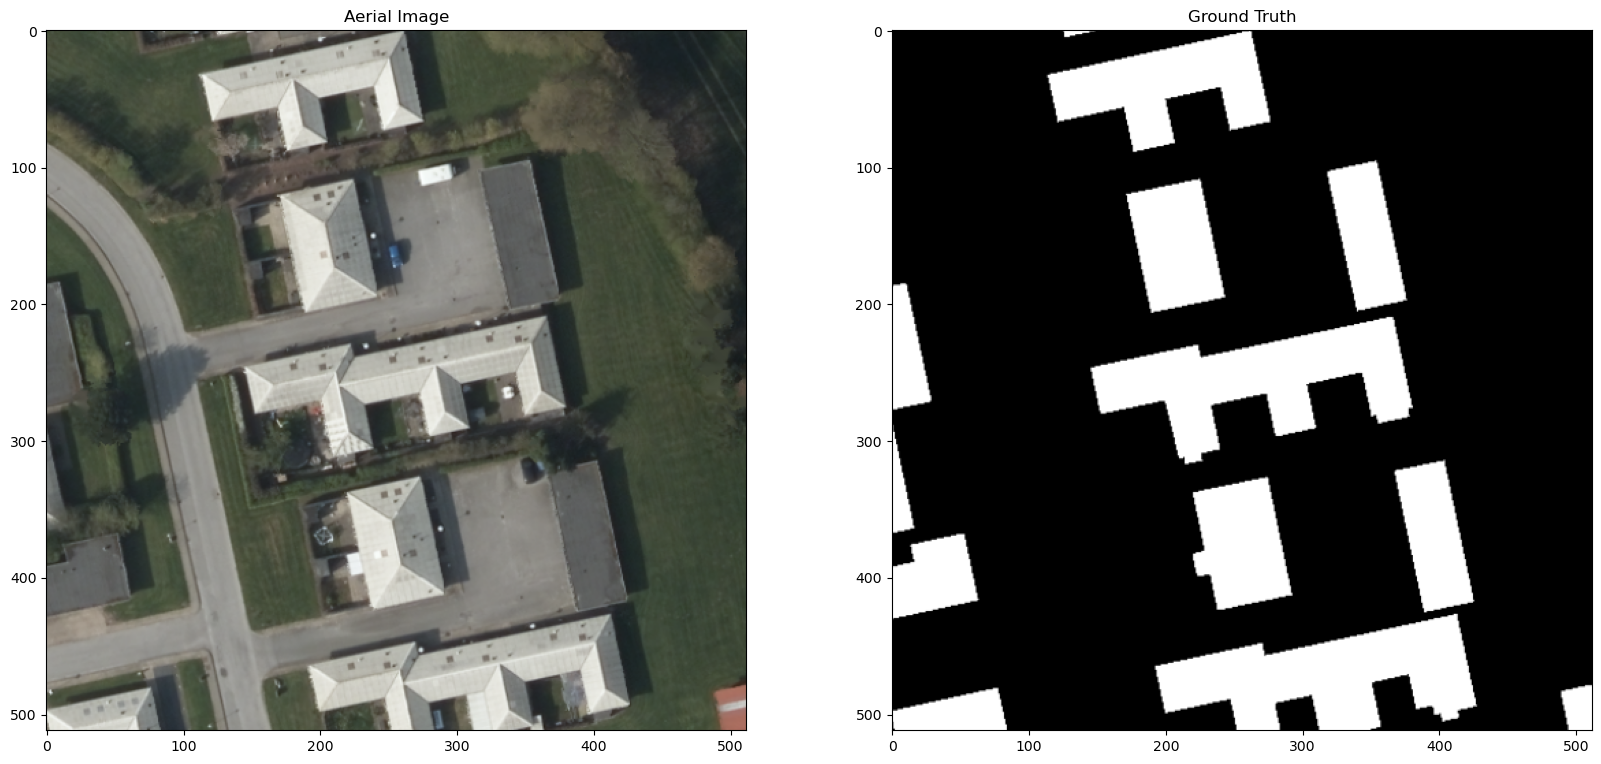

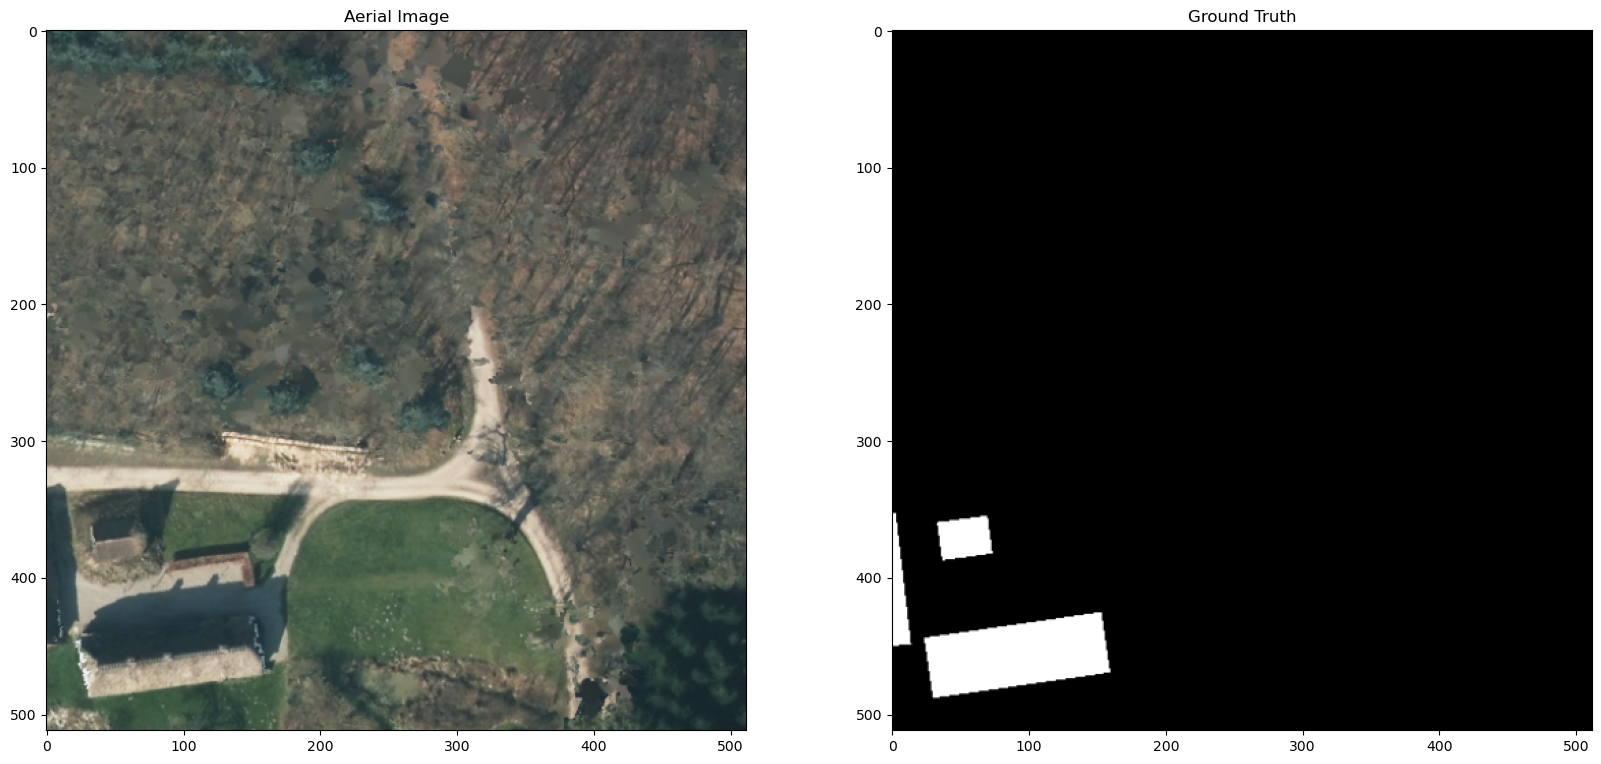

In [26]:
# Display a random image from training set
index = random.randint(0, no_train_images)

plt.figure(figsize=(20,20))
plt.subplot(221)
plt.title('Aerial Image')
plt.imshow(X_train[index])
plt.subplot(222)
plt.title('Ground Truth')
plt.imshow(Y_train[index], cmap='gray')
plt.show()

# Display a random image from validation set
index = random.randint(0, no_val_images)

plt.figure(figsize=(20,20))
plt.subplot(221)
plt.title('Aerial Image')
plt.imshow(X_train[index])
plt.subplot(222)
plt.title('Ground Truth')
plt.imshow(Y_train[index], cmap='gray')
plt.show()


## Train Model

In [ ]:
# Create callback for model. 

# ModelCheckpoint -> Creates checkpoints after each epoch
# EarlyStopping -> Stops the training of the model if it doesnt improve after some epochs
callback_list = [
    callbacks.ModelCheckpoint(os.path.normpath('models/MapAI_UNet_Task1_Checkpoint.h5'), verbose = 1, save_best_only=True),
    callbacks.EarlyStopping(monitor = 'val_loss', patience = 3)
]


# Train the model
results = model.fit(X_train, Y_train, batch_size = 16, epochs = 25, callbacks = callback_list, validation_data = (X_val, Y_val))

Epoch 1/25
  4/438 [..............................] - ETA: 3:15:39 - loss: -21.5997 - accuracy: 0.0091

In [ ]:
# Vizualize training results
acc = results.history['accuracy']
val_acc = results.history['val_accuracy']

loss = results.history['loss']
val_loss = results.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 7))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# Save model
model.save(os.path.normpath('models/unet1'))